 
 # Dataset 2015 Flight Delays and Cancellations

- Os objetivos pretendidos neste notebook são:
  - Fazer uma análise exploratória do dataset;
  - Implementar um modelo de ML que consiga classificar bem os voos que atrasaram ou não.

In [1]:
#Importação das bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para treinamento e cálculo de métricas 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.linear_model import LogisticRegression 
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

In [2]:
#Função para formatar a matriz de correlação
def plot_corr_matrix(corr_matrix, size=(14, 14)):
  # Configurando a figura do matplotlib
  fig, ax = plt.subplots(figsize=size)

  # Gerando um mapa de cores divergente personalizado
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Gerando uma máscara para o triângulo superior
  mask = np.triu(np.ones_like(corr_matrix.corr(), dtype=np.bool))

  # Desenhando o mapa de calor com a máscara e a proporção correta
  sns.heatmap(corr_matrix.corr(), mask=mask, cmap=cmap, vmax=.99, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [3]:
# Função para construir gráfico de barras
def grafico_barras_prop(data, variable):
    (data[[variable]]
     .value_counts(normalize=True, sort = False)
     .rename("Proportion")
     .reset_index()
     .pipe((sns.barplot, "data"), x=variable, y="Proportion"))
    plt.ylim(0,1)
    plt.show()

#### EDA / Pré-processamento e limpeza dos dados 

In [4]:
#Leitura dos datasets
df_airline = pd.read_csv("airlines.csv")
df_airports = pd.read_csv("airports.csv")
df_flights = pd.read_csv("flights.csv")

In [5]:
df_airline.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [6]:
df_airline.shape

(14, 2)

In [7]:
df_airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [8]:
df_airports.shape

(322, 7)

In [9]:
df_flights.head(10)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,2015,1,1,4,DL,806,N3730B,SFO,MSP,25,...,610.0,8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
6,2015,1,1,4,NK,612,N635NK,LAS,MSP,25,...,509.0,-17.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
7,2015,1,1,4,US,2013,N584UW,LAX,CLT,30,...,753.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
8,2015,1,1,4,AA,1112,N3LAAA,SFO,DFW,30,...,532.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
9,2015,1,1,4,DL,1173,N826DN,LAS,ATL,30,...,656.0,-15.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_flights.shape

(5819079, 31)

#### A partir de agora irei focar apenas no dataset 'df_flights' para as análises e modelagem

#### Descrição das variáveis do dataset:
- YEAR	= Year of the Flight Trip /  Ano da Viagem do Voo (Somente ano de 2015)
- MONTH	= Month of the Flight Trip / Mês da Viagem do Voo (de 1 a 12)
- DAY =	Day of the Flight Trip/ Dia da Viagem do Voo ( de 1 a 31)
- DAY_OF_WEEK = Day of week of the Flight Trip/ Dia da semana da viagem do voo (representado de 1 a 7 - começando na segunda)
- AIRLINE = Airline Identifier/ Identificador da Companhia Aérea (sigla 2 letras)
- FLIGHT_NUMBER	= Flight Identifier/ Identificador do Voo (4 números)
- TAIL_NUMBER = Aircraft Identifier/ Identificador da Aeronave (letras e números)
- ORIGIN_AIRPORT = Starting Airport/ Aeroporto de partida (sigla 3 letras)
- DESTINATION_AIRPORT = Destination Airport/ Aeroporto de Destino (sigla 3 letras)
- SCHEDULED_DEPARTURE = Planned Departure Time/ Horário planejado de partida (tempo em horas marinha) 
- DEPARTURE_TIME = WHEEL_OFF - TAXI_OUT /  horário realmente de partida da pista de taxi (tempo em horas marinha)
- DEPARTURE_DELAY = Total Delay on Departure/ Atraso total na partida (tempo em minutos)
- TAXI_OUT = The time duration elapsed between departure from the origin airport gate and wheels off / A duração do tempo decorrido entre a - partida do portão do aeroporto de origem até tirar as rodas do chão (tempo em minutos)
- WHEELS_OFF = The time point that the aircraft's wheels leave the ground / O ponto de tempo em que as rodas da aeronave saem do chão (tempo em horas)
- SCHEDULED_TIME = Planned time amount needed for the flight trip/ Quantidade de tempo planejada necessária para a viagem, tempo de voo (tempo em minutos)
- ELAPSED_TIME = AIR_TIME+TAXI_IN+TAXI_OUT / TEMPO DE AR + ENTRADA DE TÁXI + SAÍDA DE TÁXI (tempo em minutos)
- AIR_TIME = The time duration between wheels_off and wheels_on time / A duração do tempo entre as rodas desligadas e as rodas no ar (tempo em minutos)
- DISTANCE = Distance between two airports/ Distância entre dois aeroportos (em milhas)
- WHEELS_ON = The time point that the aircraft's wheels touch on the ground/ O ponto de tempo em que as rodas da aeronave tocam no chão (tempo em horas)
- TAXI_IN = The time duration elapsed between wheels-on and gate arrival at the destination airport/ A duração do tempo decorrido do pouso até a chegada no portão do aeroporto de destino (tempo em minutos)
- SCHEDULED_ARRIVAL	= Planned arrival time/ Hora de chegada planejada (tempo em horas)
- ARRIVAL_TIME	= WHEELS_ON+TAXI_IN / RODAS LIGADAS + ENTRADA DE TÁXI = (tempo em horas)
- ARRIVAL_DELAY	= ARRIVAL_TIME-SCHEDULED_ARRIVAL/ atraso da chegada (tempo em minutos)
- DIVERTED	= Aircraft landed on airport that out of schedule/ A aeronave pousou em um aeroporto fora do cronograma (boolean 1 = sim)
- CANCELLED	= Flight Cancelled (1 = cancelled)/ Voo Cancelado (1 = cancelado)
- CANCELLATION_REASON = Reason for Cancellation of flight: A - Airline/Carrier; B - Weather; C - National Air System; D - Security/ Motivo do cancelamento do voo: A - Companhia aérea/Transportadora; B - Clima; C - Sistema Aéreo Nacional; D - Segurança
- AIR_SYSTEM_DELAY	= Delay caused by air system/ Atraso causado pelo sistema aéreo
- SECURITY_DELAY = Delay caused by security/ Atraso causado pela segurança
- AIRLINE_DELAY	= Delay caused by the airline/ Atraso causado pela companhia aérea
- LATE_AIRCRAFT_DELAY = Delay caused by aircraft/ Atraso causado por aeronaves
- WEATHER_DELAY	= Delay caused by weather/ Atraso causado pelo clima


In [11]:
# Verificando os tipos das variáveis
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [12]:
# Transformando as variáveis com tipo object em categoricas
# Criando função para atender aos requisitos acima
def mudar_tipo(x):

    if x.dtype == "object":
        return x.astype("category")
    return x

df_flights= df_flights.apply(lambda x: mudar_tipo(x))

In [13]:
# Verificando valores duplicados
df_flights.duplicated().sum()

0

In [14]:
# Verificando valores nulos 
df_flights.isnull().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

In [15]:
# Verificando porcentagem de valores nulos 
df_flights.isnull().mean().round(4)*100

YEAR                    0.00
MONTH                   0.00
DAY                     0.00
DAY_OF_WEEK             0.00
AIRLINE                 0.00
FLIGHT_NUMBER           0.00
TAIL_NUMBER             0.25
ORIGIN_AIRPORT          0.00
DESTINATION_AIRPORT     0.00
SCHEDULED_DEPARTURE     0.00
DEPARTURE_TIME          1.48
DEPARTURE_DELAY         1.48
TAXI_OUT                1.53
WHEELS_OFF              1.53
SCHEDULED_TIME          0.00
ELAPSED_TIME            1.81
AIR_TIME                1.81
DISTANCE                0.00
WHEELS_ON               1.59
TAXI_IN                 1.59
SCHEDULED_ARRIVAL       0.00
ARRIVAL_TIME            1.59
ARRIVAL_DELAY           1.81
DIVERTED                0.00
CANCELLED               0.00
CANCELLATION_REASON    98.46
AIR_SYSTEM_DELAY       81.72
SECURITY_DELAY         81.72
AIRLINE_DELAY          81.72
LATE_AIRCRAFT_DELAY    81.72
WEATHER_DELAY          81.72
dtype: float64

#### Exclusão das variáveis com grande quantidade de valores nulos
- Devido a grande quantidade de valores nulos nessas colunas, optei por retilá-las pois dificultaria uma análise correta sobre os dados.
  - CANCELLATION_REASON    98.46
  - AIR_SYSTEM_DELAY       81.72
  - SECURITY_DELAY         81.72
  - AIRLINE_DELAY          81.72
  - LATE_AIRCRAFT_DELAY    81.72
  - WEATHER_DELAY          81.72


In [16]:
# Dropando as colunas
df_flights = df_flights.drop(columns=['CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'])

- A variável 'CANCELLED' não faz sentido para essa análise visto que se o voo foi cancelado significa que nao teve atraso e o que estamos analisando aqui são justamente os atrasos.

In [17]:
# Dropando coluna
df_flights = df_flights.drop(columns=['CANCELLED'])

- As demais variáveis tem uma quantidade inferior a 2% de dados nulos, então optei por retirar esses valores 
- Foi avaliado também as variáveis que não tinham valores nulos e devido a essa retirada foram perdidos, mesmo assim optei por essa escolha.

In [18]:
# Dropando valores nulos no restante das variáveis com menos de 2%
df_flights = df_flights.dropna(axis=0)

- Optarei por trabalhar com a variável 'DAY_OF_WEEK' como categórica, mostrando os dias da semana. 
- Segundo análise feita, o número 1 se refere a segunda feira e assim por diante.

In [19]:
# Funnção para atender ao requisito acima
def MudarValor(x):
    if x == 1:
        x = 'Segunda'
    if x == 2:
        x = 'Terca'
    if x == 3:
        x = 'Quarta'
    if x == 4:
        x = 'Quinta'
    if x == 5:
        x = 'Sexta'
    if x == 6:
        x = 'Sabado'
    if x == 7:
        x = 'Domingo'
    return x

df_flights['DAY_OF_WEEK'] = df_flights['DAY_OF_WEEK'].apply(lambda x: MudarValor(x))

- Optarei por trabalhar com as variáveis 'ARRIVAL_DELAY' e 'DEPARTURE_DELAY' como boolean
- As variáveis estão representadas em minutos: 
  - 0 sem atraso
  - minutos negativos para voos adiantados
  - minutos positivos para a contagem de atraso

In [20]:
# Função para atender aos requisitos acima
# 1 = atrasou
# 0 = não atrasou ou chegou adiantado

def MudarValor(x):
    if x <= 0:
        x = 0
    else: 
        x = 1
    return x

df_flights['ARRIVAL_DELAY'] = df_flights['ARRIVAL_DELAY'].apply(lambda x: MudarValor(x))
df_flights['DEPARTURE_DELAY'] = df_flights['DEPARTURE_DELAY'].apply(lambda x: MudarValor(x))

In [21]:
# Transformando os tipos de algumas variáveis 
df_flights.DAY_OF_WEEK = df_flights.DAY_OF_WEEK.astype('category')
df_flights.FLIGHT_NUMBER = df_flights.FLIGHT_NUMBER.astype('category')
df_flights.ARRIVAL_DELAY = df_flights.ARRIVAL_DELAY.astype('int64')
df_flights.DEPARTURE_DELAY = df_flights.DEPARTURE_DELAY.astype('int64')
df_flights.DAY = df_flights.DAY.astype('category')
df_flights.MONTH = df_flights.MONTH.astype('category')
df_flights.YEAR = df_flights.YEAR.astype('category')
df_flights.ORIGIN_AIRPORT  = df_flights.ORIGIN_AIRPORT.astype('str')
df_flights.DESTINATION_AIRPORT = df_flights.DESTINATION_AIRPORT.astype('str')

In [22]:
# verificando a distribuição da variável de desvio de voo (pouso em aeroporto fora do cronograma)
df_flights[["DIVERTED"]].value_counts(sort = False)

DIVERTED
0           5714008
dtype: int64

In [23]:
df_flights = df_flights.drop(columns=['DIVERTED'])

- Após o tratamento do dataframe a variável 'DIVERTED' ficou apenas com valores 0 (sem desvio de voo), devido as linhas que foram dropadas. Como eram apenas menos de 2 % de valores perdidos, optei por manter essa decisão e não trabalhar com essa variável. 
- Menos de 2% de valores referentes aos voos desviados nao seriam suficientes para se fazer uma análise se teria relação com os atrasos dos voos.

In [24]:
# Verificando o dataset tratado
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5714008 entries, 0 to 5819078
Data columns (total 23 columns):
 #   Column               Dtype   
---  ------               -----   
 0   YEAR                 category
 1   MONTH                category
 2   DAY                  category
 3   DAY_OF_WEEK          category
 4   AIRLINE              category
 5   FLIGHT_NUMBER        category
 6   TAIL_NUMBER          category
 7   ORIGIN_AIRPORT       object  
 8   DESTINATION_AIRPORT  object  
 9   SCHEDULED_DEPARTURE  int64   
 10  DEPARTURE_TIME       float64 
 11  DEPARTURE_DELAY      int64   
 12  TAXI_OUT             float64 
 13  WHEELS_OFF           float64 
 14  SCHEDULED_TIME       float64 
 15  ELAPSED_TIME         float64 
 16  AIR_TIME             float64 
 17  DISTANCE             int64   
 18  WHEELS_ON            float64 
 19  TAXI_IN              float64 
 20  SCHEDULED_ARRIVAL    int64   
 21  ARRIVAL_TIME         float64 
 22  ARRIVAL_DELAY        int64   
dtypes: cate

In [25]:
# verificando tamanho depois dos tratamentos
df_flights.shape

(5714008, 23)

In [26]:
# Separando as variáveis:
# Variável de interesse
target = 'ARRIVAL_DELAY'
print('target:', target)

# Variáveis numéricas
vars_num = df_flights.select_dtypes(include=['int', 'float']).columns.tolist()
print(f'\nVariáveis numéricas({len(vars_num)}): {vars_num}')

# Variáveis categóricas
vars_cat = df_flights.select_dtypes(exclude=['int', 'float']).columns.tolist()
print(f'\nVariáveis Categóricas({len(vars_cat)}): {vars_cat}')

target: ARRIVAL_DELAY

Variáveis numéricas(14): ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY']

Variáveis Categóricas(9): ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']


In [27]:
# Medidas de resumo das variáveis quantitativas
df_flights.drop(columns=['DEPARTURE_DELAY', 'ARRIVAL_DELAY']).describe(percentiles = [.25, .50, .75, .95, .99], include=['int64', 'float64']).round(2)

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME
count,5714008.00,5714008.00,5714008.00,5714008.00,5714008.00,5714008.00,5714008.00,5714008.00,5714008.00,5714008.00,5714008.00,5714008.00
mean,1328.91,1335.07,16.07,1357.10,141.89,137.01,113.51,824.46,1471.32,7.43,1493.19,1476.37
std,483.53,496.42,8.88,498.02,75.31,74.21,72.23,608.66,521.87,5.62,506.90,525.97
min,1.00,1.00,1.00,1.00,18.00,14.00,7.00,31.00,1.00,1.00,1.00,1.00
25%,916.00,921.00,11.00,935.00,85.00,82.00,60.00,373.00,1054.00,4.00,1110.00,1058.00
50%,1325.00,1330.00,14.00,1343.00,123.00,118.00,94.00,650.00,1508.00,6.00,1520.00,1512.00
75%,1730.00,1740.00,19.00,1754.00,174.00,168.00,144.00,1065.00,1911.00,9.00,1917.00,1916.00
95%,2115.00,2132.00,31.00,2143.00,309.00,299.00,273.00,2239.00,2243.00,16.00,2247.00,2246.00
99%,2245.00,2300.00,50.00,2307.00,377.00,367.00,337.00,2588.00,2341.00,30.00,2346.00,2343.00
max,2359.00,2400.00,225.00,2400.00,718.00,766.00,690.00,4983.00,2400.00,248.00,2400.00,2400.00


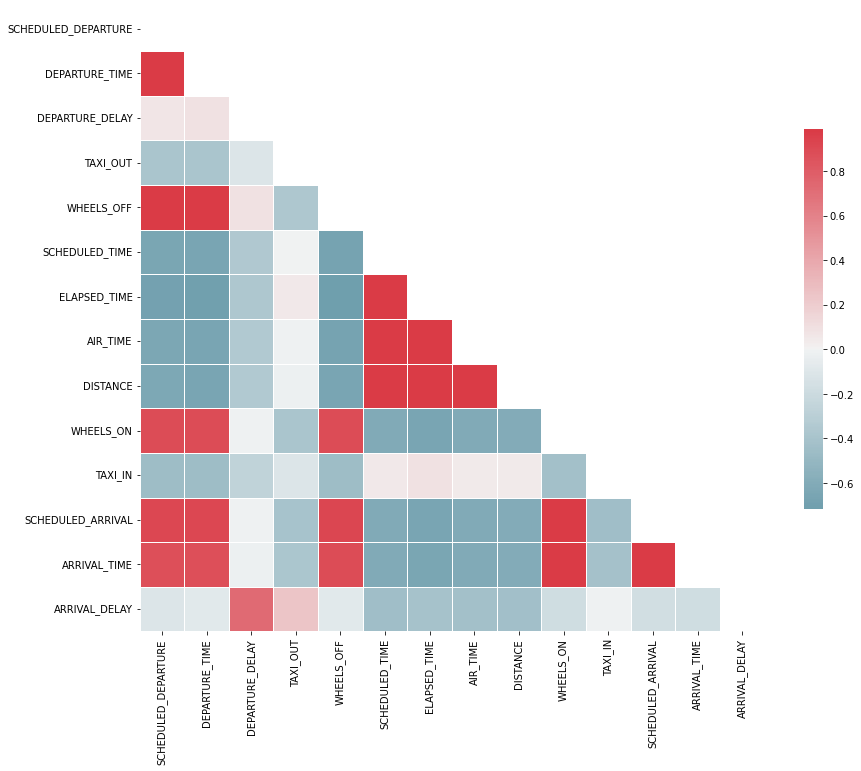

In [28]:
# Verificando correlacao entre as variaveis 
corr_matrix = df_flights[vars_num].corr()
plot_corr_matrix(corr_matrix)

- Verificando o mapa acima, podemos perceber uma maior correlação entre a variável de interesse e a 'DEPARTURE_DELAY', o que na minha opnião já era esperado, pois normalmente se um voo tem atraso na partida, provavelmente ele chegará atrasado no destino. Mesmo levando em consideraçao que o piloto poderia acelerar durante o voo para compensar o atraso da partida e dentre outros detalhes. Por esse motivo não irei colocar a variavel 'DEPARTURE_DELAY' no modelo.

#### Análise univariada e bivariada de algumas features

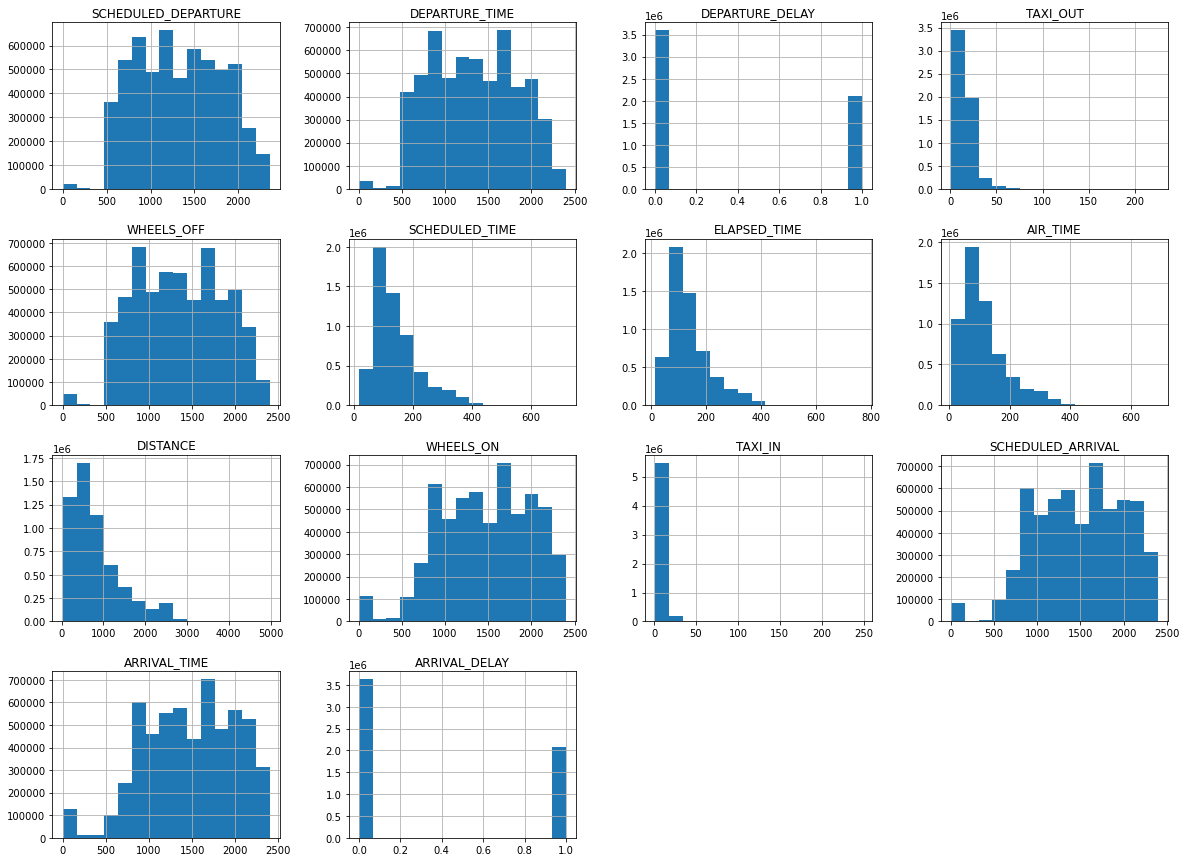

In [29]:
# Histograma das variáveis numéricas
df_flights.hist(bins=15, figsize=(20,15));

- A partir dos histogramas acima, é possivel perceber as diferenças em algumas distribuições, isso devido a algumas serem em horas e outras em minutos e ainda outras serem booleanas.
- A distância dos voos vai até 3000 milhas, isso por se tratarem de voos domésticos. Essa mesma análise pode ser feita para o tempo de voo. 


In [30]:
# Distribuição da variável de interesse
df_flights[['ARRIVAL_DELAY']].value_counts(sort = False)

ARRIVAL_DELAY
0                3627112
1                2086896
dtype: int64

<AxesSubplot:xlabel='ARRIVAL_DELAY', ylabel='count'>

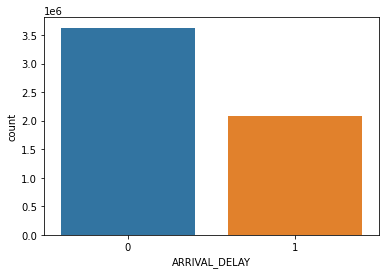

In [31]:
sns.countplot(data=df_flights, x="ARRIVAL_DELAY")

In [32]:
# Distribuição da variável DEPARTURE_DELAY
df_flights[['DEPARTURE_DELAY']].value_counts(sort = False)

DEPARTURE_DELAY
0                  3598959
1                  2115049
dtype: int64

<AxesSubplot:xlabel='DEPARTURE_DELAY', ylabel='count'>

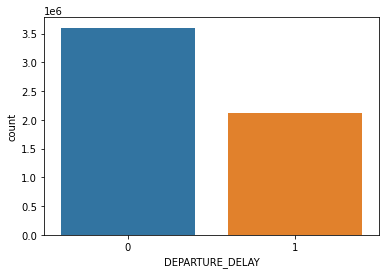

In [33]:
# visualizando a variável DEPARTURE_DELAY
sns.countplot(data=df_flights, x="DEPARTURE_DELAY")

In [34]:
# Verificando a distribuiição dos voos entre os dias da semana 
df_flights[['DAY_OF_WEEK']].value_counts(sort = False)

DAY_OF_WEEK
Domingo        802555
Quarta         843242
Quinta         857886
Sabado         689745
Segunda        841794
Sexta          851387
Terca          827399
dtype: int64

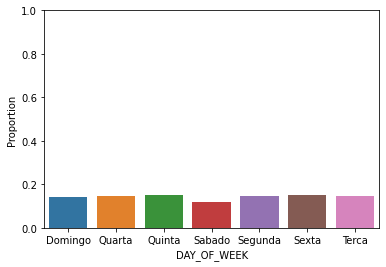

In [35]:
# Verificando a distribuiição dos voos entre os dias da semana
grafico_barras_prop(df_flights, variable = "DAY_OF_WEEK")

<AxesSubplot:xlabel='DAY_OF_WEEK', ylabel='ARRIVAL_DELAY'>

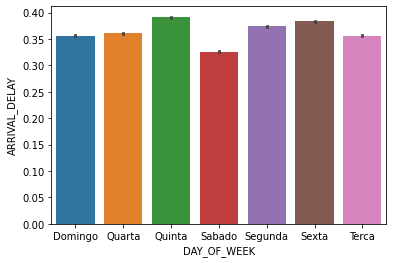

In [36]:
# Verificando relação entre os dias da semana e os atrasos nas chegadas ao destino
sns.barplot(data=df_flights, x="DAY_OF_WEEK", y="ARRIVAL_DELAY")

- Com as duas análises acima, não se ver uma diferença significante dos voos entre os dias da semana; 
- É possivel perceber também que no sábado se tem uma menor quantidade de voos e também de atrasos;
- Nos demais dias, percebemos uma distribuição bem parecida.

In [37]:
# Verificando a distribuiição dos voos entre os meses do ano 
df_flights[['MONTH']].value_counts(sort = False)

MONTH
1        457013
2        407663
3        492138
4        479251
5        489641
6        492847
7        514384
8        503956
9        462153
10       482878
11       462367
12       469717
dtype: int64

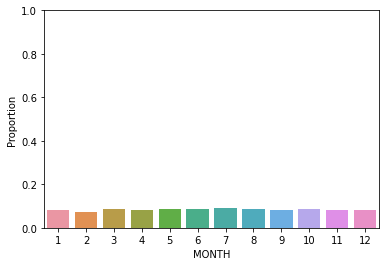

In [38]:
# Verificando a distribuiição dos voos entre os meses do ano 
grafico_barras_prop(df_flights, variable = "MONTH")

<AxesSubplot:xlabel='MONTH', ylabel='ARRIVAL_DELAY'>

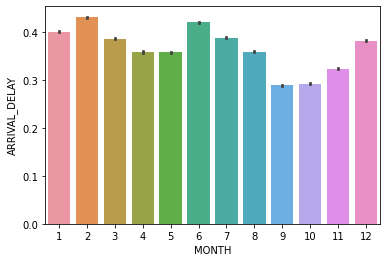

In [39]:
# Verificando relação entre os os meses do ano e os atrasos nas chegadas ao destino
sns.barplot(data=df_flights, x="MONTH", y="ARRIVAL_DELAY")

- Já em relação aos meses do ano, não necessariamente os meses com maior quantidade de voos tem maior quantidade de atrasos.
- Os meses entre dezembro e março tem um aumento de atrasos que podem estar relacionados ao período de inverno.
- Os meses de junho a setembro são meses de verão, onde observamos também uma maior quantidades de atrasos nos dois primeiros meses.

In [40]:
# Verificando a distribuição dos voos entre as companhias aereas
df_flights[['AIRLINE']].value_counts(sort = False)

AIRLINE
AA          712935
AS          171439
B6          262042
DL          870275
EV          554752
F9           90090
HA           76041
MQ          278791
NK          115193
OO          576814
UA          507762
US          194223
VX           61248
WN         1242403
dtype: int64

<AxesSubplot:xlabel='AIRLINE', ylabel='ARRIVAL_DELAY'>

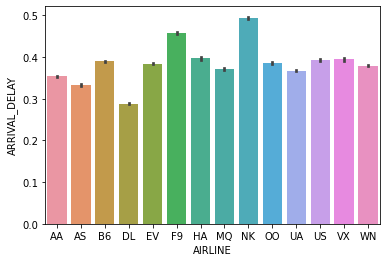

In [41]:
# Verificando relação entre as companhias aereas e os atrasos nas chegadas ao destino
sns.barplot(data=df_flights, x="AIRLINE", y="ARRIVAL_DELAY") 

- Aqui também não é possível associar os atrasos as companhias com maior quantidade de voos
- As companhias com maior número de atrasos são:  
  - NK - Spirit Air Lines
  - F9 - Frontier Airlines Inc.

<AxesSubplot:xlabel='ARRIVAL_DELAY', ylabel='DISTANCE'>

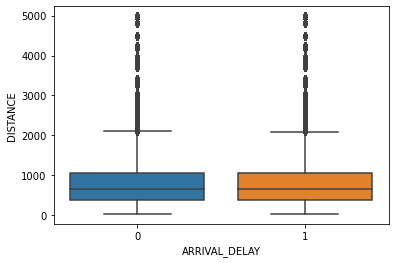

In [42]:
# Verificando relação entre a distância e os atrasos nas chegadas ao destino
sns.boxplot(data=df_flights, x="ARRIVAL_DELAY", y="DISTANCE")

- Em ambos os casos, estão bem parecidos, não podendo ser possível fazer alguma associação em relação as distâncias e os atrasos

- Como a variável 'ORIGIN_AIRPORT' e 'DESTINATION_AIRPORT' tem uma variação grande e visualmente não conseguimos analisar todos, vou mostrar os 5 aeroportos com maior e menor quantidades de atrasos, tanto para o de origem como o de destino.

In [43]:
# Filtrando apenas aeroportos com atrasos (=1)
filtro_atraso_origem = df_flights.ARRIVAL_DELAY == 1
df_agrupado_atraso_origem = df_flights.loc[filtro_atraso_origem]

In [44]:
# Contagem dos atrasos por aeroporto de origem (os 5 com mais atrasos)
df_agrupado = df_agrupado_atraso_origem.groupby(['ORIGIN_AIRPORT']).ARRIVAL_DELAY.count().sort_values(ascending=False)
df_agrupado.head(5)

ORIGIN_AIRPORT
ATL    114872
ORD    113281
DFW     93054
DEN     80756
LAX     79661
Name: ARRIVAL_DELAY, dtype: int64

In [45]:
# Filtrando apenas aeroportos de destino com atrasos (=1)
filtro_atraso_destino = df_flights.ARRIVAL_DELAY == 1
df_agrupado_atraso_destino = df_flights.loc[filtro_atraso_destino]

In [46]:
# Contagem dos atrasos por aeroporto de destino (os 5 com mais atrasos)
df_agrupado2 = df_agrupado_atraso_destino.groupby(['DESTINATION_AIRPORT']).ARRIVAL_DELAY.count().sort_values(ascending=False)
df_agrupado2.head(5)

DESTINATION_AIRPORT
ATL    105603
ORD    104224
DFW     83312
LAX     81985
DEN     71443
Name: ARRIVAL_DELAY, dtype: int64

- Com as análises acima, percebemos que os aeroportos com maior número de atrasos são os mesmos, tanto para os areroportos de origem como de destino.

### Modelagem 
- Na etapa de modelagem irei construir alguns modelos para executar a tarefa de classificação dos voos entre atrasados ou sem atrasos. Utilizarei três modelos de classificação: Logistic Regression, Random Forest e XGBoost.

In [47]:
#Transformando as variáveis textuais para rodar nos modelos
label_encoder = LabelEncoder() 
df_flights['DAY_OF_WEEK_ENCODER'] = label_encoder.fit_transform(df_flights['DAY_OF_WEEK']) 
df_flights['AIRLINE_ENCODER'] = label_encoder.fit_transform(df_flights['AIRLINE']) 
df_flights['FLIGHT_NUMBER_ENCODER'] = label_encoder.fit_transform(df_flights['FLIGHT_NUMBER']) 
df_flights['TAIL_NUMBER_ENCODER'] = label_encoder.fit_transform(df_flights['TAIL_NUMBER']) 
df_flights['ARRIVAL_DELAY_ENCODER'] = label_encoder.fit_transform(df_flights['ARRIVAL_DELAY']) 
df_flights['YEAR_ENCODER'] = label_encoder.fit_transform(df_flights['YEAR']) 
df_flights['MONTH_ENCODER'] = label_encoder.fit_transform(df_flights['MONTH']) 
df_flights['DAY_ENCODER'] = label_encoder.fit_transform(df_flights['DAY']) 
df_flights['ORIGIN_AIRPORT_ENCODER'] = label_encoder.fit_transform(df_flights['ORIGIN_AIRPORT']) 
df_flights['DESTINATION_AIRPORT_ENCODER'] = label_encoder.fit_transform(df_flights['DESTINATION_AIRPORT']) 

#### Split - Treino/Teste-Básico

In [48]:
# Conjunto com variáveis escolhidas 
X = df_flights[['YEAR_ENCODER', 'MONTH_ENCODER', 'DAY_ENCODER', 'DAY_OF_WEEK_ENCODER', 'AIRLINE_ENCODER', 'FLIGHT_NUMBER_ENCODER', 
'TAIL_NUMBER_ENCODER', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 
'DISTANCE','WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ORIGIN_AIRPORT_ENCODER', 'DESTINATION_AIRPORT_ENCODER']]
y = df_flights['ARRIVAL_DELAY_ENCODER']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.30, 
                                                    stratify=y,
                                                    random_state = 42)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

#### Treinamento do modelo Logistic Regression 

In [49]:
# Criando o modelo Regressão Logistica
model_reg_log = LogisticRegression()   
  
# Treinamento do modelo Regressão Logistica
model_reg_log.fit(X_train, y_train)

# Predições
y_pred = model_reg_log.predict(X_test)

#### Calculando as métricas do modelo Logistic Regression - Básico

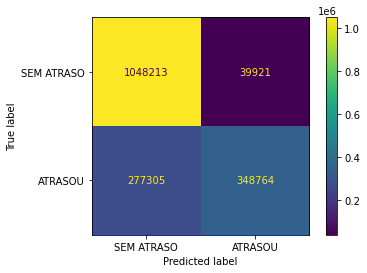

In [50]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['SEM ATRASO', 'ATRASOU'])
_ = disp.plot(values_format='d')

In [51]:
print("Acurácia: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=0))
print('Recall:', recall_score(y_test, y_pred, pos_label=0))
print('F1 Score:', f1_score(y_test, y_pred))

Acurácia:  0.8149425709790498
Precision: 0.7907949948623859
Recall: 0.9633124229185008
F1 Score: 0.687386302493018


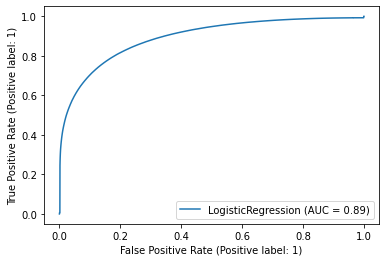

In [52]:
plot_roc_curve(model_reg_log, X_test, y_test)

In [53]:
# Importância das features, removendo variáveis pouco importantes
print('Running permutation feature importance')
permutation_result = permutation_importance(model_reg_log,  X_test, y_test, n_repeats=5, random_state=42)

Running permutation feature importance


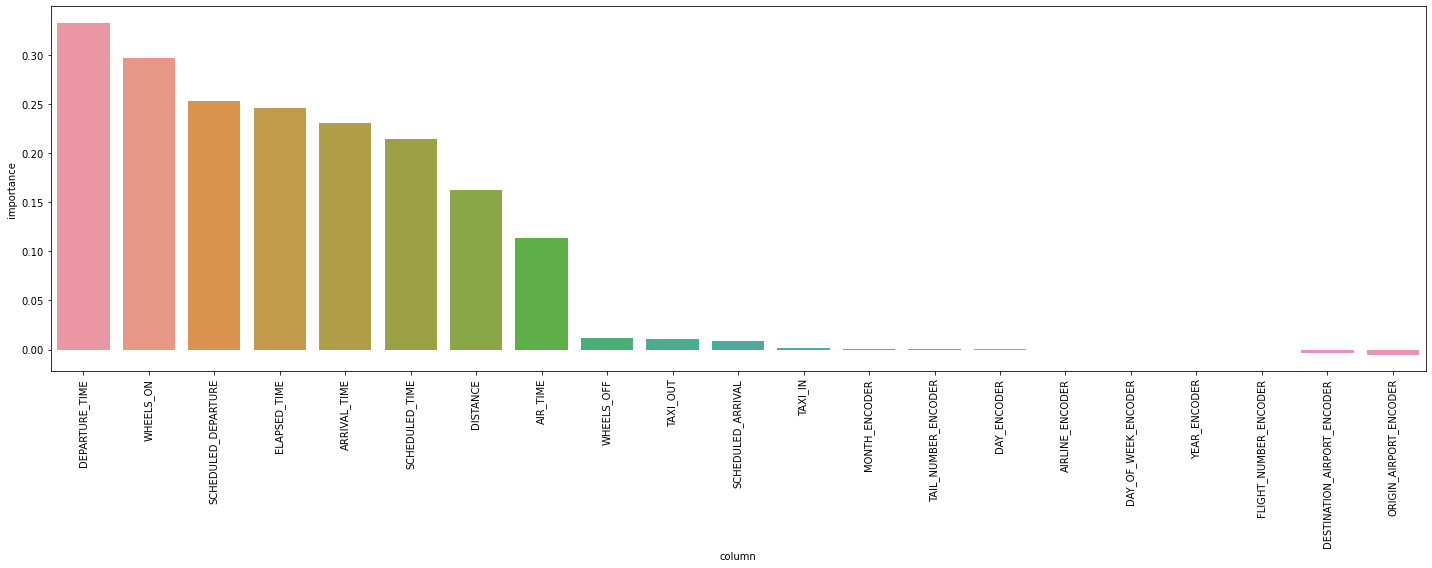

In [54]:
# plotando o permutation feature importance
importances = pd.DataFrame({'column' : X_test.columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(20,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()

#### Treinamento do modelo RandomForest 

In [55]:
# Criando o modelo Random Forest 
model_ran_forest = RandomForestClassifier(n_estimators = 5, random_state = 42)   
  
# Treinamento do modelo Random Forest em CPU
model_ran_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=42)

In [56]:
# Predições
y_pred = model_ran_forest.predict(X_test)

#### Calculando as métricas do modelo RandomForest

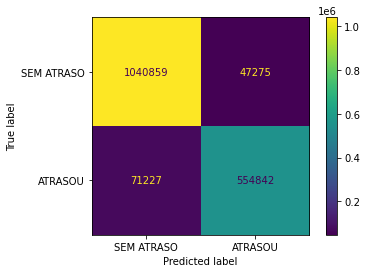

In [57]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['SEM ATRASO', 'ATRASOU'])
_ = disp.plot(values_format='d')

In [58]:
print("Acurácia: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=0))
print('Recall:', recall_score(y_test, y_pred, pos_label=0))
print('F1 Score:', f1_score(y_test, y_pred))

Acurácia:  0.9308704978348539
Precision: 0.9359518958066193
Recall: 0.9565540641134272
F1 Score: 0.9035146142359545


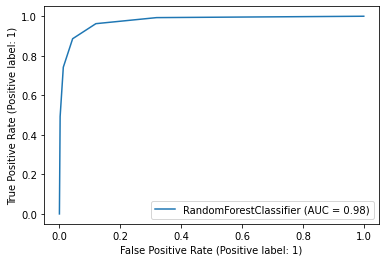

In [59]:
plot_roc_curve(model_ran_forest, X_test, y_test)

In [60]:
# Importância das features, removendo variáveis pouco importantes
print('Running permutation feature importance')
permutation_result = permutation_importance(model_ran_forest,  X_test, y_test, n_repeats=5, random_state=42)

Running permutation feature importance


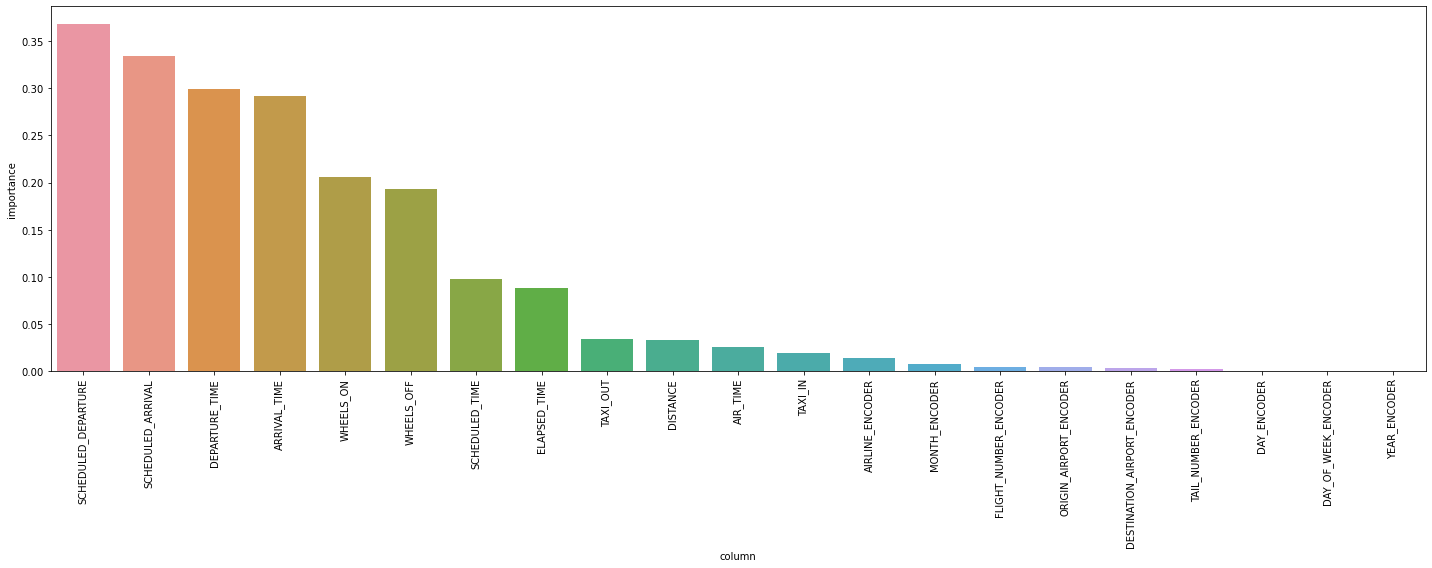

In [61]:
# plotando o permutation feature importance
importances = pd.DataFrame({'column' : X_test.columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(20,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()

#### Treinamento do modelo XGBoost

In [62]:
# Parametrização do XGBoost
params = {'learning_rate': 0.1,
          'colsample_bytree' : 0.3,
          'max_depth': 5,
          'objective': 'binary:logistic',
          'alpha' : 10,
          'n_estimators': 100}

# Treinamento do modelo XGBoost
model_XGboost = XGBClassifier(**params)
model_XGboost.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric='auc', verbose=False)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', ...)

In [63]:
# Predições
y_pred = model_XGboost.predict(X_test)

#### Calculando as métricas do modelo XGBoost 

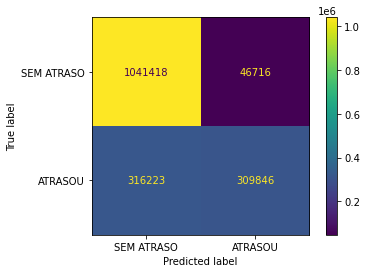

In [64]:
cm = confusion_matrix(y_test, y_pred.astype(np.int64))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['SEM ATRASO', 'ATRASOU'])
_ = disp.plot(values_format='d')

In [65]:
print("Acurácia: ", accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=0))
print('Recall:', recall_score(y_test, y_pred, pos_label=0))
print('F1 Score:', f1_score(y_test, y_pred))

Acurácia:  0.788275367619821
Precision: 0.7670790731865051
Recall: 0.957067787607041
F1 Score: 0.6306456849010462


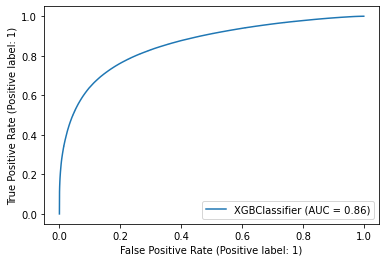

In [66]:
plot_roc_curve(model_XGboost, X_test, y_test)

In [67]:
# Importância das features, removendo variáveis pouco importantes
print('Running permutation feature importance')
permutation_result = permutation_importance(model_XGboost,  X_test, y_test, n_repeats=5, random_state=42)

Running permutation feature importance


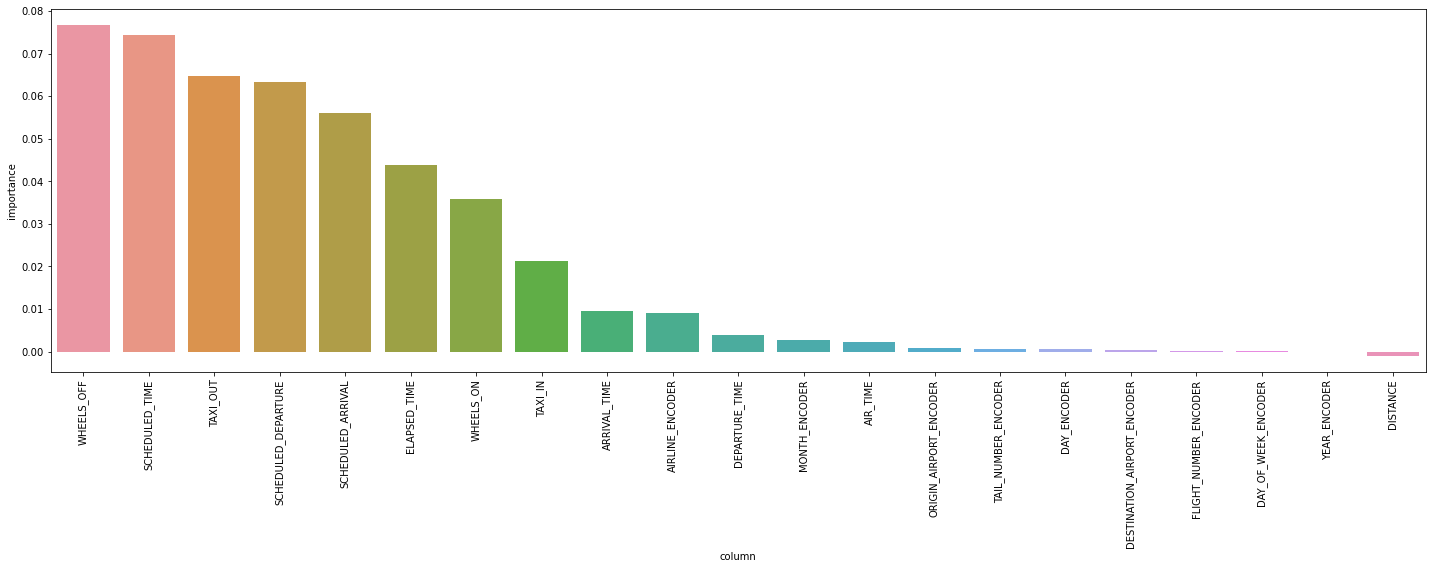

In [68]:
# plotando o permutation feature importance
importances = pd.DataFrame({'column' : X_test.columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(20,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()

#### Comparação dos 3 modelos

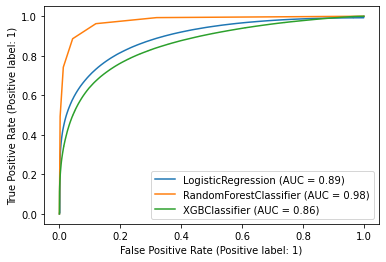

In [69]:
# Comparando as curvas roc dos 3 modelos
classifiers = [model_reg_log, model_ran_forest, model_XGboost]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

In [70]:
# Comparação das métricas dos 3 modelos 
for i in classifiers:
    y_pred = i.predict(X_test)
    print(f'**{type(i).__name__}**')
    print(f'Acurácia: {round(accuracy_score(y_test, y_pred), 2)}\nPrecisão: {round(precision_score(y_test, y_pred), 2)}\nRecall: {round(recall_score(y_test, y_pred), 2)}\nRF1 Score: {round(f1_score(y_test, y_pred), 2)}')
    print('__________________')

**LogisticRegression**
Acurácia: 0.81
Precisão: 0.9
Recall: 0.56
RF1 Score: 0.69
__________________
**RandomForestClassifier**
Acurácia: 0.93
Precisão: 0.92
Recall: 0.89
RF1 Score: 0.9
__________________
**XGBClassifier**
Acurácia: 0.79
Precisão: 0.87
Recall: 0.49
RF1 Score: 0.63
__________________


#### Comentários finais 
- A partir da comparação dos 3 modelos, o segundo modelo RandomForestClassifier foi o que si saiu melhor, tanto em relação a curva roc como das métricas de avaliação. Sendo o modelo escolhido entre os 3.
- O XGBClassifier foi o modelo com pior performance. 
- Observando a matrix de correlação, o modelo escolhido conseguiu errar menos que os demais modelos de forma geral.
- Sobre as variáveis com maior importância para os modelos, cada modelo mudou um pouco o peso da importância entre as variáveis, mas no geral as mesmas variáveis se mantem entre as primeiras.
- Melhorias futuras:
  - Poderia focar em melhorar as métricas do modelo escolhido;
  - Testar usar apenas as variáveis com maior relevância no feature importance;
  - Fazer um Feature engineering e colocar as novas variáveis no modelo;
  - Ampliar as análises feitas inicialmente.